In [1]:
cd ..

/home/bimi/bimi/robotics/av/sanjyot/latcom


In [42]:
# datetime.strftime()

'2020-12-18-14-42-08'

# Import

In [2]:
from pathlib import Path
from datetime import datetime, timedelta
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
    from preprocess import preprocess_image
    from data import CE491data
    from models import load_nvidia

	Configuration Settings 
	config_yaml: fusion_sanjyot



Using TensorFlow backend.


In [6]:
batch_size = 64

# CE491 class

In [8]:
Path.cwd()

PosixPath('/home/bimi/bimi/robotics/av/sanjyot/latcom')

In [9]:
project_dir = Path.cwd()
data_dir = project_dir / 'dataset'
summary_filename= 'summary.csv'
split_info = {
    'train': [
        'yild5350/2019-12-13-14-54-15',
        'yild5350/2019-12-14-17-01-33',
#         'Jaku6779/2019-12-07-18-14-00',
    ],
    'valid': [
        'Jaku6779/2019-12-16-19-31-06',
        'yild5350/2019-12-15-17-13-05',
#         'jack4815/2019-12-15-21-09-25',
    ]
}

time_shift = 1000

ce = CE491data(
    data_dir=data_dir, 
    summary_filename=summary_filename, 
    time_shift=time_shift,
    batch_size=batch_size, 
    split_info=split_info, 
    cache=True
)
train_gen, valid_gen, t, v = ce.get_train_valid_generators()

Shifting labels by 1000 ms.
Time shift executed: Mean=1002.0 Low=980.0 High=1020.0
Time shift executed: Mean=1002.1 Low=984.0 High=1017.0
Shifting labels by 1000 ms.
Time shift executed: Mean=1002.4 Low=980.2 High=1019.9
Time shift executed: Mean=1001.9 Low=984.4 High=1019.8
Training data count: 21602
Validation data count: 27886


# Train

In [10]:
%load_ext tensorboard

In [11]:
log_dir = project_dir / 'logs'
if not log_dir.exists():
    log_dir.mkdir(parents=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=str(log_dir), histogram_freq=1,
    update_freq='batch',
    write_images=False)

In [12]:
nvidia = load_nvidia(input_shape=(40, 80, 3), learning_rate=1e-4)
nvidia.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 40, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 20, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 10, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 5, 64)          27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)               0         
_______________________________________

In [13]:
epochs = 3

history = nvidia.fit_generator(
    train_gen,
    epochs=epochs,
    steps_per_epoch=np.ceil(len(t)/float(batch_size)),
    verbose=1,
    validation_data=valid_gen,
    max_queue_size=20,
    workers=8,
    validation_steps=np.ceil(len(v)/float(batch_size)),
    callbacks=[tensorboard_callback],
    use_multiprocessing=True
)

/home/bimi/anaconda3/envs/tf1/lib/python2.7/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/3
338/338 [==============================] - 29s 85ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 2.2669e-05 - val_mse: 7.8878e-04
Epoch 2/3
338/338 [==============================] - 29s 87ms/step - loss: 5.3631e-04 - mse: 5.3631e-04 - val_loss: 3.9063e-05 - val_mse: 8.4476e-04
Epoch 3/3
338/338 [==============================] - 28s 83ms/step - loss: 5.0184e-04 - mse: 5.0184e-04 - val_loss: 5.6884e-05 - val_mse: 5.0474e-04


In [11]:
model_number = '5_ts{}'.format(time_shift)
weight_name = 'model{}_weights_only.h5'.format(model_number)
config_name = 'model{}_config_only.json'.format(model_number)
history_name = 'model{}_history.pkl'.format(model_number)
model_dir = project_dir / 'models'

weight_path = model_dir / weight_name
model_config_path = model_dir / config_name
history_path = model_dir / history_name
print(weight_path)
print(model_config_path)
print(history_path)

/home/bimi/bimi/robotics/av/working/latcom/models/model5_ts1000_weights_only.h5
/home/bimi/bimi/robotics/av/working/latcom/models/model5_ts1000_config_only.json
/home/bimi/bimi/robotics/av/working/latcom/models/model5_ts1000_history.pkl


In [12]:
if not model_dir.exists():
    model_dir.mkdir()

nvidia.save_weights(weight_path)

json_config = nvidia.to_json()
with open(str(model_config_path), 'w') as json_file:
    json_file.write(json_config)

import cPickle as pickle
with open(str(history_path), 'wb') as f:
    pickle.dump(history, f)

# Evaluation

## Load model

In [13]:
def load_model(config_path, weight_path):
    with open(str(config_path)) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)

    model.load_weights(str(weight_path))
    model.compile(
        loss='mse',
        optimizer='adam',
        metrics=['mse']
    )
    return model

In [14]:
nvidia = load_model(model_config_path, weight_path)

In [15]:
nvidia.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 40, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 20, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 10, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 5, 64)          27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)              

## Training convergence

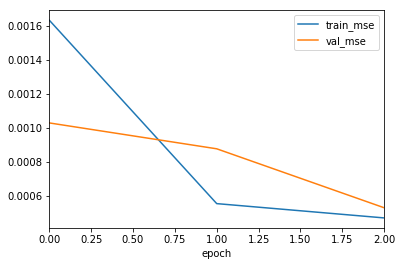

In [16]:
_ = (
    pd.DataFrame(history.history)
    .reset_index()
    .rename(columns={'index': 'epoch', 'mse': 'train_mse'})
    .plot(x='epoch', y=['train_mse', 'val_mse'], kind='line')
)

## Steering angle prediction

In [17]:
pred = nvidia.predict_generator(valid_gen, steps=np.ceil(len(v)/float(batch_size)), verbose=1)

436/436 [==============================] - 56s 128ms/step


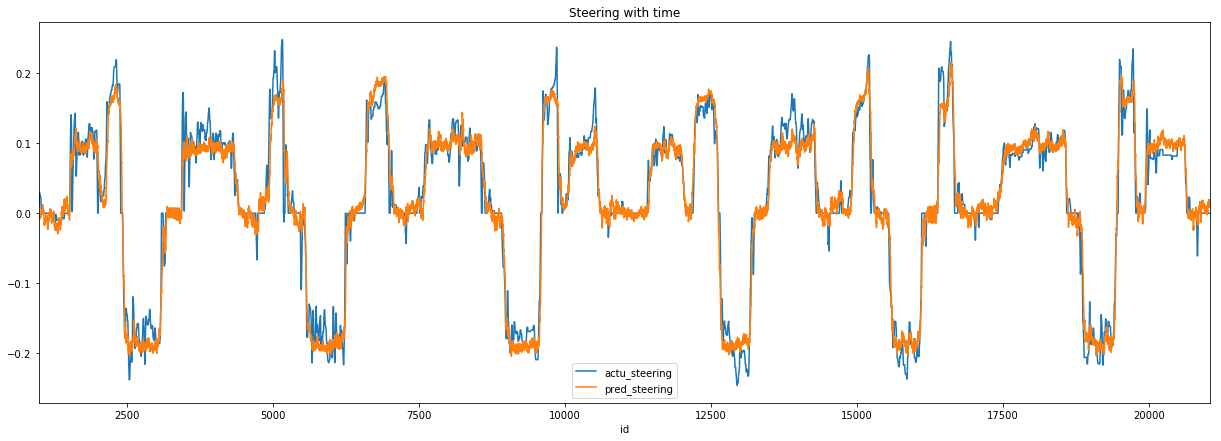

In [18]:
res = (
    v
    .assign(pred_steering = pred)
    .assign(pred_steering_movavg = lambda x: x['pred_steering'].rolling(30).mean())
    .reset_index()
    .rename(columns={'steering': 'actu_steering', 'index': 'id'})
)

ax = res[:20000].plot(x='id', y=[
    'actu_steering',
    'pred_steering', 
#     'pred_steering_movavg'
                        ], kind='line', figsize=(21, 7))
_ = ax.set_title('Steering with time')

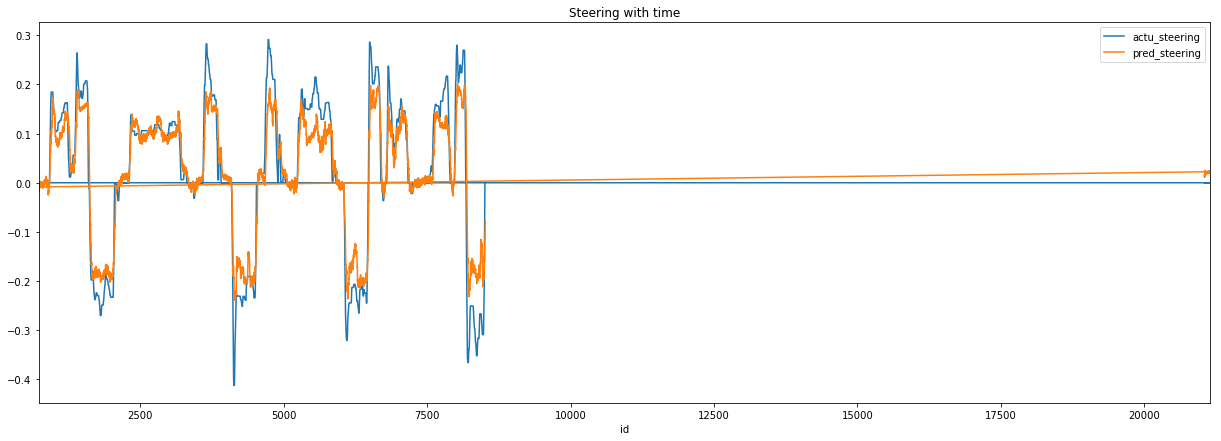

In [19]:
ax = res[20000:].plot(x='id', y=[
    'actu_steering',
    'pred_steering', 
#     'pred_steering_movavg'
                        ], kind='line', figsize=(21, 7))
# ax.set_xlim(0,40000)
_ = ax.set_title('Steering with time')

In [28]:
print('MSE: {}'.format(round(((res['actu_steering'] - res['pred_steering'])**2).mean(), 5)))

MSE: 0.00125


## Steering angle prediction zoomed in

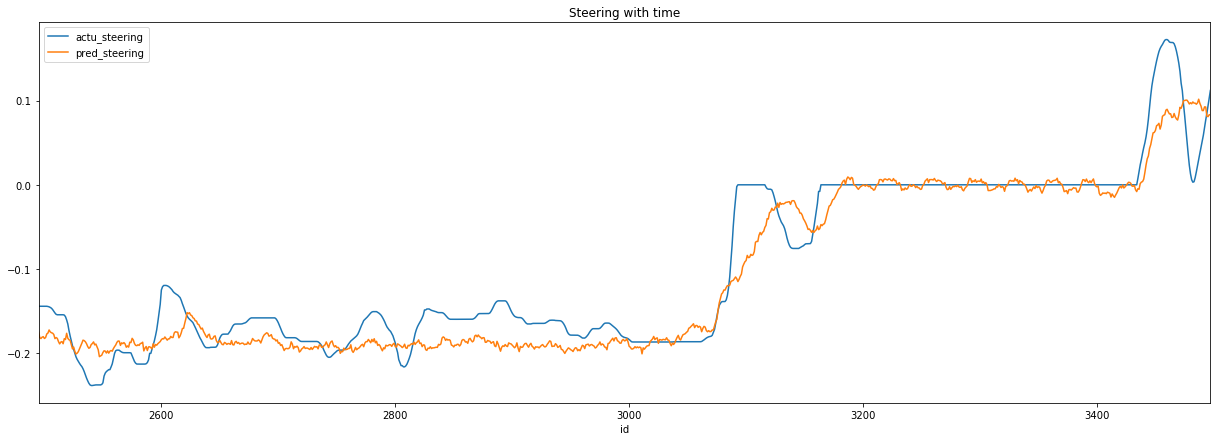

In [29]:
ax = res[1500:2500].plot(x='id', y=[
    'actu_steering',
    'pred_steering', 
#     'pred_steering_movavg'
                        ], kind='line', figsize=(21, 7))
_ = ax.set_title('Steering with time')

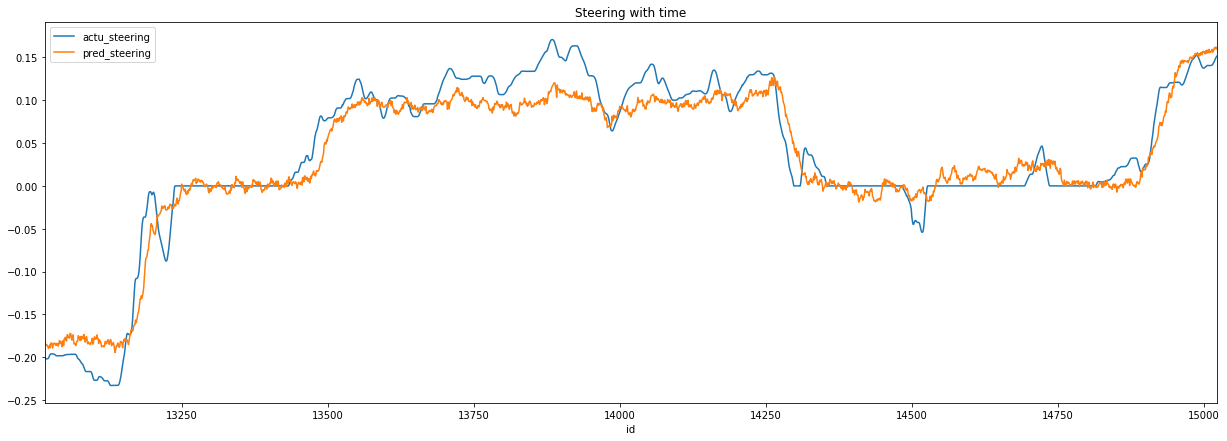

In [33]:
ax = res[12000:14000].plot(x='id', y=[
    'actu_steering',
    'pred_steering', 
#     'pred_steering_movavg'
                        ], kind='line', figsize=(21, 7))
_ = ax.set_title('Steering with time')